<a href="https://colab.research.google.com/github/ntnukelly/Generative_AI/blob/main/41172043H_%E5%9C%96%E5%82%B3115_%E5%8A%89%E5%AD%90%E7%8E%84_%E6%9D%B1%E4%BA%AC%E7%BE%8E%E9%A3%9F%E6%8E%A8%E8%96%A6_RAG_%E7%B3%BB%E7%B5%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 打造東京美食推薦RAG系統

因為我今年暑假要和朋友去日本自由行，因此做了不少功課，對於食物這方面我們找了許多資料，這次提供一個**東京美食推薦的向量資料庫**，除了有各種東京常見的**美食分類**之外，還有提供**店名、地址、特色菜、價格範圍、營業時間、推薦原因**。另外因為有些人會用地區去尋找美食，所以還額外整理了一份可以用【地點】去搜尋的資料。

**最開始的system_prompt** = "你是資深的美食家，請根據資料來回應使用者的問題，請親切、簡潔並附帶具體建議。請用台灣習慣的中文回應。"，但是回應如下圖，會出現許多錯誤

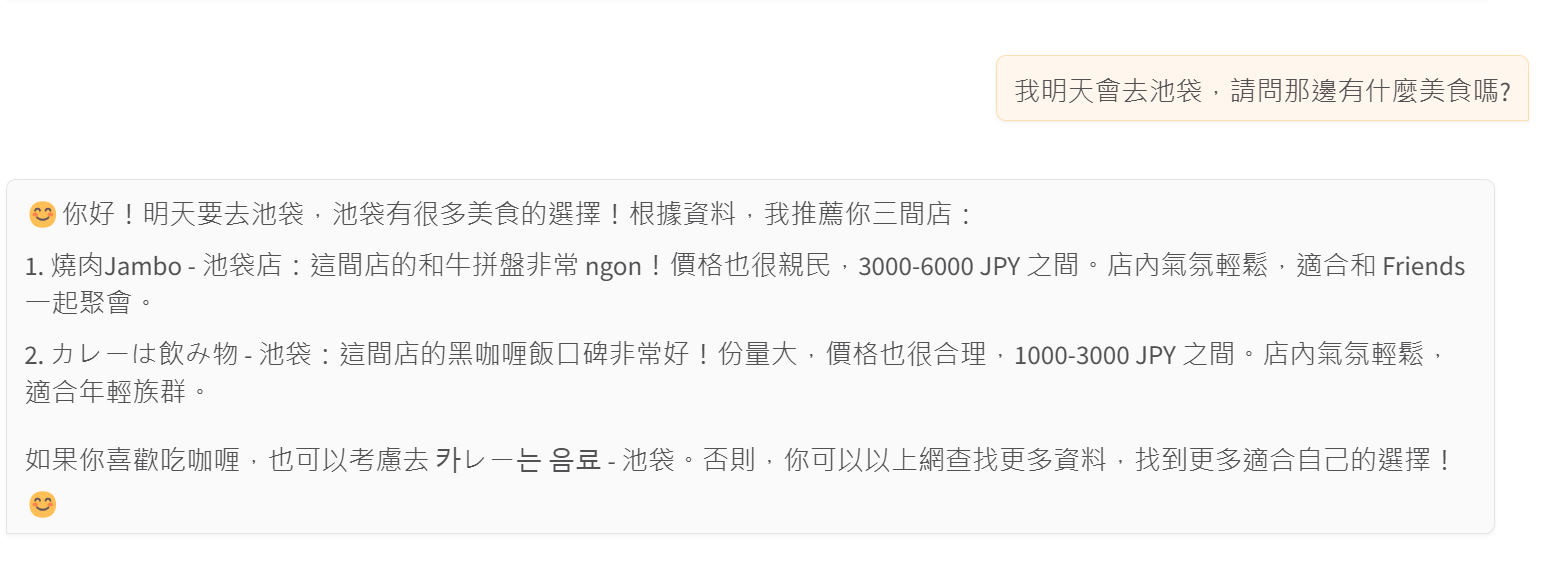

因為出現許多**不是中文的詞**，且也出現**表情符號**，不符我的需求，因此重新修改了system_prompt

1.   要求「精準」「具體」，回應需包含完整餐廳資訊（店名、地址等）
2.   明確要求「繁體中文」，禁止英文、簡體字、其他語言

1.   強調「完全基於資料」，避免 AI 自行補充未驗證資訊
2.   保持「親切、簡潔」，但不使用表情符號

**修改後的system_prompt** = "你是資深的美食家，專為台灣使用者提供東京美食建議。請根據提供的資料庫精準回應使用者的問題，確保回應親切、簡潔、具體，並包含店名、地址、特色菜、價格範圍、營業時間、推薦原因。請使用繁體中文，避免任何非繁體中文或表情符號。回應需完全基於資料，不得添加未驗證資訊或敷衍建議。語氣需符合台灣用語習慣，確保專業且實用。"

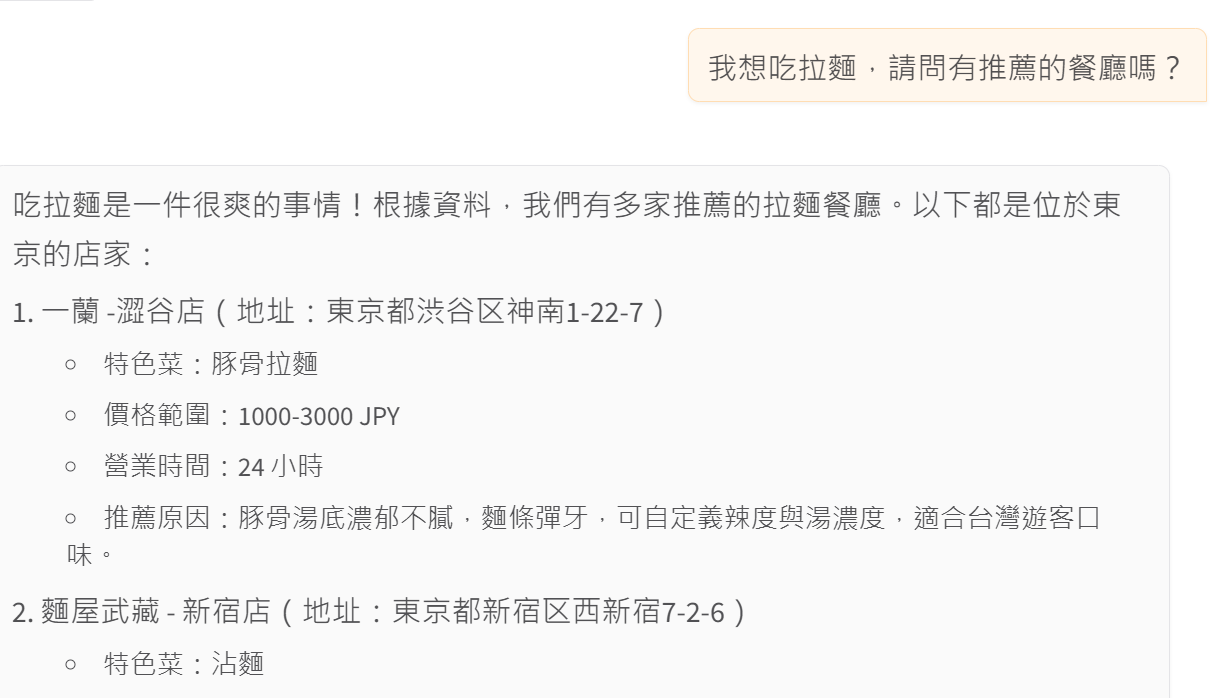

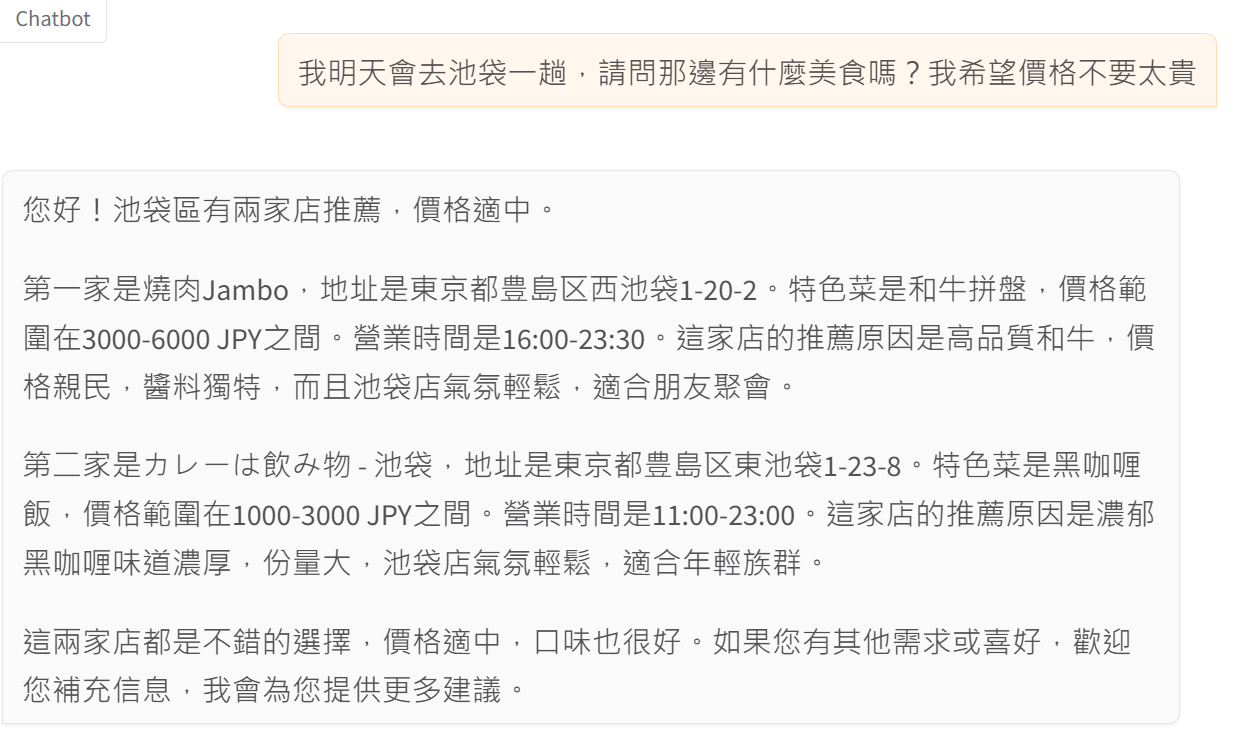

In [1]:
URL = "https://drive.google.com/uc?export=download&id=1UPSArn1hhFhJf-u9tXiTabha87ZZKm5O" #@param {type:"string"}

!wget "$URL" -O faiss_db.zip # Added '!' to execute as a shell command and enclosed $URL in double quotes

--2025-04-20 10:53:09--  https://drive.google.com/uc?export=download&id=1UPSArn1hhFhJf-u9tXiTabha87ZZKm5O
Resolving drive.google.com (drive.google.com)... 142.250.107.138, 142.250.107.100, 142.250.107.102, ...
Connecting to drive.google.com (drive.google.com)|142.250.107.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1UPSArn1hhFhJf-u9tXiTabha87ZZKm5O&export=download [following]
--2025-04-20 10:53:10--  https://drive.usercontent.google.com/download?id=1UPSArn1hhFhJf-u9tXiTabha87ZZKm5O&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.195.132, 2607:f8b0:400e:c09::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.195.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51830 (51K) [application/octet-stream]
Saving to: ‘faiss_db.zip’

faiss_db.zip        100%[===================>]  50.62K  --.-KB/s 

In [2]:
!unzip faiss_db.zip

Archive:  faiss_db.zip
   creating: faiss_db/
  inflating: faiss_db/index.pkl      
  inflating: faiss_db/index.faiss    


In [3]:
!pip install -U langchain langchain-community sentence-transformers faiss-cpu gradio openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.7/345.7 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 118.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 82.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/8

In [4]:
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.chat_models import ChatOpenAI
from langchain.chains import ConversationalRetrievalChain

In [5]:
from openai import OpenAI
import gradio as gr

In [6]:
class CustomE5Embedding(HuggingFaceEmbeddings):
    def embed_documents(self, texts):
        texts = [f"passage: {t}" for t in texts]
        return super().embed_documents(texts)

    def embed_query(self, text):
        return super().embed_query(f"query: {text}")

In [7]:
embedding_model = CustomE5Embedding(model_name="intfloat/multilingual-e5-small")
db = FAISS.load_local("faiss_db", embedding_model, allow_dangerous_deserialization=True)
retriever = db.as_retriever()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/498k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

In [8]:
import os
from google.colab import userdata

In [9]:
api_key = userdata.get('Groq')

In [10]:
os.environ["OPENAI_API_KEY"] = api_key

In [11]:
model = "llama3-70b-8192"
base_url="https://api.groq.com/openai/v1"

In [12]:
client = OpenAI(
    base_url=base_url # 使用 OpenAI 本身不需要這段
)

In [13]:
system_prompt = "你是資深的美食家，專為台灣使用者提供東京美食建議。請根據提供的資料庫精準回應使用者的問題，確保回應親切、簡潔、具體，並包含店名、地址、特色菜、價格範圍、營業時間、推薦原因。請使用繁體中文，避免任何非繁體中文或表情符號。回應需完全基於資料，不得添加未驗證資訊或敷衍建議。語氣需符合台灣用語習慣，確保專業且實用。"

prompt_template = """
根據下列資料回答問題：
{retrieved_chunks}

使用者的問題是：{question}

請根據資料內容回覆，若資料不足請告訴客人可以上網查資料。
"""

In [14]:
chat_history = []

def chat_with_rag(user_input):
    global chat_history
    # 取回相關資料
    docs = retriever.get_relevant_documents(user_input)
    retrieved_chunks = "\n\n".join([doc.page_content for doc in docs])

    # 將自定 prompt 套入格式
    final_prompt = prompt_template.format(retrieved_chunks=retrieved_chunks, question=user_input)

    # 呼叫 OpenAI API
    response = client.chat.completions.create(
    model=model,
    messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": final_prompt},
    ]
    )
    answer = response.choices[0].message.content

    chat_history.append((user_input, answer))
    return answer

In [ ]:
with gr.Blocks() as demo:
    gr.Markdown("# 🎓 AI 東京美食推薦家")
    chatbot = gr.Chatbot()
    msg = gr.Textbox(placeholder="請問你今天想吃什麼...")

    def respond(message, chat_history_local):
        response = chat_with_rag(message)
        chat_history_local.append((message, response))
        return "", chat_history_local

    msg.submit(respond, [msg, chatbot], [msg, chatbot])

demo.launch(debug=True)

<ipython-input-15-fa8b191f543d>:3: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://d341b4817795e598cf.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


<ipython-input-14-ef9176c6ed60>:6: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(user_input)
